C:\Users\tjtur\AppData\Local\Temp/ipykernel_20460/1475230711.py:134: RuntimeWarning: divide by zero encountered in log
  log_p = np.log(pressure)


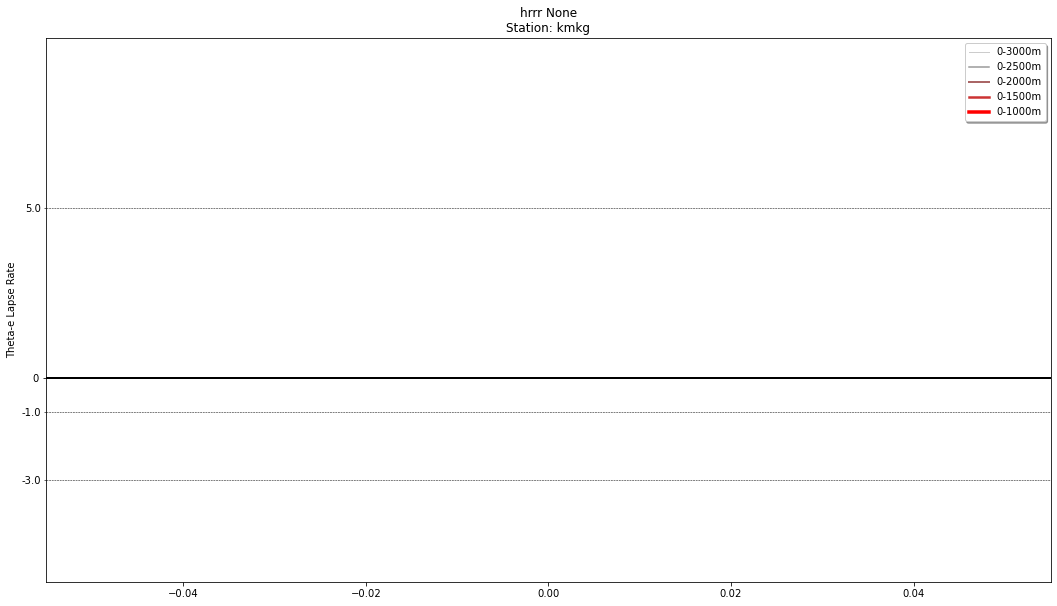

In [50]:
from metpy.units import units
import numpy as np
from metpy import calc
from scipy import interpolate
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import re

class ThetaE_Parser():
    
    def __init__(self, model, stid, runtime=None):
        self.model = model # 'hrrr'
        self.stid = stid # 'kgrr'
        self.master = {}
        self.surface = {}
        self.plotting = []
        #self.df = None
        self.runtime = runtime # '21120606'
        self.file_path_base = 'C:/Users/Public/Bufkit/Data/'


        if runtime is None:
            self.file_path = f'{self.file_path_base}{self.model}_{self.stid}.buf'
            self.figure_title = "{} {}\nStation: {}".format(self.model,self.runtime,self.stid)            
        else:
            self.file_path = f'{self.file_path_base}{self.runtime}.{self.model}_{self.stid}.buf'
            self.figure_title = "{} {}\nStation: {}".format(self.model,self.runtime,self.stid)

        fin = open(self.file_path,'r')
        self.data = fin.read()
        #print(self.data)
        fin.close()
        self.forecast_hours = self.data.split("STID = ")
        for h in range(1,len(self.forecast_hours)):
            dat = self.forecast_hours[h]
            self.parse_forecast_hour_data(dat)
        
        self.parse_sfc_data(self.forecast_hours[-1],self.stid)
        for key in self.master:
        # 211203/1900
            try:
                dt = datetime.strptime(key, '%y%m%d/%H%M')

                dat = self.master[key]['data']
                sfc_temperature = self.master[key]['surface_temperature']

                sfc_theta_e = self.master[key]['surface_theta_e']
                pressures = dat[:,0]
                logs = dat[:,1]
                thetaes = dat[:,2]
                heights = dat[:,3]
                temperatures = dat[:,4]

                temperature_h8 = self.interpol(np.log(850.0), logs, temperatures)
                delta_t = self.clean_difference(temperature_h8,sfc_temperature)
                
                theta_e_1000 = self.converge(1000.0, heights, thetaes)
                theta_e_1500 = self.converge(1500.0, heights, thetaes)
                theta_e_2000 = self.converge(2000.0, heights, thetaes)
                theta_e_2500 = self.converge(2500.0, heights, thetaes)
                theta_e_3000 = self.converge(3000.0, heights, thetaes)
                dte_1000 = -1 * self.clean_difference(sfc_theta_e,theta_e_1000)
                dte_1500 = -1 * self.clean_difference(sfc_theta_e,theta_e_1500)
                dte_2000 = -1 * self.clean_difference(sfc_theta_e,theta_e_2000)
                dte_2500 = -1 * self.clean_difference(sfc_theta_e,theta_e_2500)
                dte_3000 = -1 * self.clean_difference(sfc_theta_e,theta_e_3000)        

                this = [dt, delta_t, dte_1000, dte_1500, dte_2000, dte_2500, dte_3000]
                
                self.plotting.append(this)
            except:
                pass

        self.df = pd.DataFrame(data=self.plotting, columns=["dt", "delta_t","dte_1000", "dte_1500", "dte_2000",  "dte_2500", "dte_3000"])
        self.df.set_index('dt', inplace=True)

        fig = plt.figure(figsize=(18,10))

        ax1 = fig.add_subplot(111)
        ax1.plot(self.df["dte_3000"], color='#cccccc', linewidth=1, label="0-3000m", zorder=2)
        ax1.plot(self.df["dte_2500"], color='#999999', linewidth=1.5, label="0-2500m", zorder=3)
        ax1.plot(self.df["dte_2000"], color='#aa6666', linewidth=2, label="0-2000m", zorder=4)
        ax1.plot(self.df["dte_1500"], color='#cc3333', linewidth=2.5, label="0-1500m", zorder=5)
        ax1.plot(self.df["dte_1000"], color='#ff0000', linewidth=3.5, label="0-1000m", zorder=6)

        plt.ylim(-6, 10)
        ax1.set_yticks([0.0], minor=False)
        ax1.set_yticks([-1.0,-3.0,5.0], minor=True)
        ax1.yaxis.grid(True, which='major')
        ax1.grid(color='k', linestyle='-', axis='y', linewidth=2, which='major', zorder=7)
        ax1.grid(color='k', linestyle='--', axis='y', linewidth=0.5, which='minor', zorder=7)
        ax1.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
        ax1.set_axisbelow(False)
        plt.ylabel('Theta-e Lapse Rate')
        plt.title(self.figure_title)


        #ax1.yaxis.grid(True, which='minor')
        ax1.legend(shadow=True, fancybox=True)
        #df.plot()



    def calc_thetae(self,p,t,dp=None):
        temperature = units.Quantity(t - 273.15, 'degC')
        pressure = units.Quantity(p, 'hPa')
        theta = calc.potential_temperature(pressure,temperature)

        if dp is not None:
            dewpoint = units.Quantity(dp, 'degC')
            theta_e = calc.equivalent_potential_temperature(pressure,temperature,dewpoint)
            return round(theta_e.magnitude, 3), round(theta.magnitude, 3)
        else:
            return -9999, round(theta.magnitude, 3)

    def parse_forecast_hour_data(self,dat):
        """
        parses data for each hour
        Returns:
        list of 
        """
        this_array = []
        lines = dat.split("\n")
        fh = lines[0].split(" ")[-1]
        self.stid = lines[0].split(" ")[-4]
        for line in lines:
            this_row = []
            vals = line.split(" ")
            if line[:1].isdigit() and '/' not in line:
                if len(vals) > 2:
                    pressure = float(vals[0])
                    log_p = np.log(pressure)
                    try:
                        temperature = float(vals[1])
                    except:
                        temperature = 999
                    theta_e = float(vals[4])
                elif len(vals) == 2:
                    height = float(vals[1])
                    ignore,theta = self.calc_thetae(pressure,temperature,None)
                    this_row = [pressure, log_p, theta_e, height, temperature + 273.15, theta + 273.15]
                    #print(this_row)
                    this_array.append(this_row)

        self.master[fh] = {'data':np.array(this_array)}
        return

    def get_value(self,line,n):
        """
        Parameters:
            line: string with spaces
            n: the index of the list created by splitting spaces
        """
        values = line.split(" ")
        return values[n]

    def parse_sfc_data(self,dat,stn_id):
        surface = {}
        fhrs = dat.split(stn_id)
        for h in range(3,len(fhrs)):
            try:
                vals = fhrs[h].split("\n")
                dt = get_value(vals[0],1)
                sfc_pressure = float(self.get_value(vals[0],3))
                sfc_temperature = float(self.get_value(vals[2],5)) + 273.15
                sfc_dewpoint = float(self.get_value(vals[5],0))
                sfc_theta_e, sfc_theta = self.calc_thetae(sfc_pressure,sfc_temperature,sfc_dewpoint)
                self.master[dt].update({"surface_temperature":sfc_temperature, "surface_theta_e":sfc_theta_e, "surface_theta":sfc_theta })
            except:
                pass

        return
    

    def converge(self,reference, levels, values):
        """
            Finds the closest model vertical levels above and below a reference height, then performs
            an interpolation between those levels to estimate a value at the reference height.

            Parameters
            ----------
                  reference : integer
                              Desired height (m AGL) at which to make the calculation
                     levels : list of integers
                              Heights (m AGL) corresponding to the available bufkit model levels.

            Returns
            -------
                      final : float
                              calculated interpolated value at the reference height.
        """
        for n in range(0,len(levels)):
            check_low = levels[n]
            check_high = levels[n+1]
            if check_low <= reference and check_high >= reference:
                #print(check_low,values[n],check_high,values[n+1],reference)
                fraction = (reference - check_low)/(check_high - check_low)
                slope = values[n + 1] - values[n]
                final = values[n] + fraction*slope
                return final
            else:
                pass

        return
    
    def interpol(self,level,x,y):
        f = interpolate.interp1d(x, y, assume_sorted = False)
        val = np.interp(level, f.x, f.y)
        return val

    def clean_difference(self,v1,v2):
        difference = v1 - v2
        return round(difference,2)



doit = ThetaE_Parser('hrrr','kmkg')